In [1]:
import os 
import pandas as pd
import requests
import matplotlib.pyplot as plt
import requests
from pprint import pprint
import gmaps
from statsmodels.formula.api import ols
from config import Api_Key
from scipy import stats

In [2]:
# Configure gmaps
gmaps.configure(api_key=Api_Key)

In [3]:
file = "Resources/Road_Crashes_for_five_Years_-_Victoria.csv"

main_df = pd.read_csv(file)

main_df.head()


,X,Y,objectid,accident_no,abs_code,accident_status,accident_date,date_value,Daily_Rainfall,accident_time,...,deg_urban_all,lga_name_all,region_name_all,srns,srns_all,rma,rma_all,divided,divided_all,stat_div_name
0,2498217.170,2454870.252,1,T20140013514,ABS to receive accident,Unfinished,1/7/2014,41821,0.6,13:09:00,...,TOWNS,MITCHELL,NORTHERN REGION,B,B,Arterial Highway,"Local Road,Arterial Highway",Undivided,Undivided,Country
1,2502934.960,2423005.289,2,T20140013549,ABS to receive accident,Finished,2/7/2014,41822,0.0,0:01:00,...,MELB_URBAN,WHITTLESEA,METROPOLITAN NORTH WEST REGION,NaN,NaN,Arterial Other,Arterial Other,Undivided,Undivided,Metro
2,2520154.039,2395621.674,3,T20140013561,ABS to receive accident,Finished,2/7/2014,41822,0.0,8:30:00,...,MELB_URBAN,KNOX,METROPOLITAN SOUTH EAST REGION,NaN,NaN,Local Road,Local Road,Undivided,Undivided,Metro
3,2473719.463,2402357.319,4,T20140013563,ABS to receive accident,Finished,2/7/2014,41822,0.0,10:08:00,...,MELB_URBAN,WYNDHAM,METROPOLITAN NORTH WEST REGION,C,C,Arterial Other,"Arterial Other,Local Road",Divided,"Undivided,Divided",Metro
4,2484073.998,2409123.682,5,T20140013567,ABS to receive accident,Finished,2/7/2014,41822,0.0,9:12:00,...,MELB_URBAN,WYNDHAM,METROPOLITAN NORTH WEST REGION,NaN,NaN,Arterial Other,"Arterial Other,Local Road",Undivided,Undivided,Metro


In [4]:
#Print a list of columns, so we can find out which column we need
print(main_df.columns.tolist())

['X', 'Y', 'objectid', 'accident_no', 'abs_code', 'accident_status', 'accident_date', 'date_value', 'Daily_Rainfall', 'accident_time', 'alcoholtime', 'accident_type', 'day_of_week', 'dca_code', 'hit_run_flag', 'light_condition', 'police_attend', 'road_geometry', 'severity', 'speed_zone', 'run_offroad', 'node_id', 'longitude', 'latitude', 'node_type', 'lga_name', 'region_name', 'vicgrid_x', 'vicgrid_y', 'total_persons', 'inj_or_fatal', 'fatality', 'seriousinjury', 'otherinjury', 'noninjured', 'males', 'females', 'bicyclist', 'passenger', 'driver', 'pedestrian', 'pillion', 'motorist', 'unknown', 'ped_cyclist_5_12', 'ped_cyclist_13_18', 'old_pedestrian', 'old_driver', 'young_driver', 'alcohol_related', 'unlicencsed', 'no_of_vehicles', 'heavyvehicle', 'passengervehicle', 'motorcycle', 'publicvehicle', 'deg_urban_name', 'deg_urban_all', 'lga_name_all', 'region_name_all', 'srns', 'srns_all', 'rma', 'rma_all', 'divided', 'divided_all', 'stat_div_name']


In [5]:
#Created a new DataFrame, and took out some of the columns. 
#Feel free to delete more, I didn't limit the columns to our discussed topics, as there maybe more ideas later and we may use the extra columns

crash_df = main_df[['accident_no',  'accident_date', 'date_value', 
                      'Daily_Rainfall', 'accident_time', 'alcoholtime', 
                      'accident_type', 'day_of_week', 'dca_code', 
                      'hit_run_flag', 'light_condition', 'police_attend', 
                      'road_geometry', 'severity', 'speed_zone', 
                      'run_offroad', 'longitude', 'latitude', 
                      'lga_name', 'region_name', 'total_persons', 
                      'inj_or_fatal', 'fatality', 'seriousinjury', 
                      'otherinjury', 'noninjured', 
                      'males', 'females',  
                      'alcohol_related','stat_div_name']]

In [6]:
#Display the dataframe
crash_df.head()

,accident_no,accident_date,date_value,Daily_Rainfall,accident_time,alcoholtime,accident_type,day_of_week,dca_code,hit_run_flag,...,total_persons,inj_or_fatal,fatality,seriousinjury,otherinjury,noninjured,males,females,alcohol_related,stat_div_name
0,T20140013514,1/7/2014,41821,0.6,13:09:00,No,Collision with vehicle,Monday,RIGHT THROUGH,No,...,4.0,1.0,0.0,0.0,1.0,3.0,1.0,3.0,No,Country
1,T20140013549,2/7/2014,41822,0.0,0:01:00,Yes,Collision with vehicle,Wednesday,U TURN,No,...,4.0,3.0,0.0,0.0,3.0,1.0,0.0,3.0,No,Metro
2,T20140013561,2/7/2014,41822,0.0,8:30:00,No,collision with some other object,Wednesday,STRUCK OBJECT ON CARRIAGEWAY,No,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,No,Metro
3,T20140013563,2/7/2014,41822,0.0,10:08:00,No,Collision with vehicle,Wednesday,CROSS TRAFFIC(INTERSECTIONS ONLY),Yes,...,3.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,No,Metro
4,T20140013567,2/7/2014,41822,0.0,9:12:00,No,Collision with vehicle,Wednesday,RIGHT THROUGH,No,...,2.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,No,Metro


In [7]:
#---------Proposed topics---------
#-       Suburb vs accident numbers, display on Gmap (AJ)
#-       Days of the week vs Accident numbers (SK)
#-       Number of accident vs suburb (AJ)
#-       Number of accident vs Region 
#-       Light condition (groupby) vs number of accident... 
#                 -what else could be closely related to light condition (Corrolation/Linea regression)
#-       Nearest hospital vs suburbs that have the highest accident (Google Place API, Gmap) (JD)
#-       Multi-line plot for Type of accident, over the 5 years (AJ)
#-       Alcohol vs Dead end ["road_geometry"] (for fun!) (KK)
#-       Rainfall vs accident numbers (SK)
#-       Rainfall vs hit and run (KK)

In [8]:
#-----Jing's Part-------

In [9]:
#-       Nearest medical centre vs suburbs that have the highest accident (Google Place API, Gmap) (JD)

In [10]:
#Create a new Dataframe for Jing's part of analayst, so it's not going to affect other team members work
suburb_df = crash_df[['accident_no',  'accident_date', 'date_value', 
                      'accident_type',  'dca_code', 
                      'light_condition','longitude', 'latitude', 
                      'lga_name', 'region_name']]

In [11]:
#Remove rows without Longitude and Latitude (including those with "-1" value)
suburb_df_LatLng_cleaned = suburb_df.dropna()
suburb_df_LatLng_cleaned = suburb_df_LatLng_cleaned.loc[(suburb_df_LatLng_cleaned["longitude"] != -1)]

In [12]:
suburb_df_LatLng_cleaned.head()

,accident_no,accident_date,date_value,accident_type,dca_code,light_condition,longitude,latitude,lga_name,region_name
0,T20140013514,1/7/2014,41821,Collision with vehicle,RIGHT THROUGH,Day,144.979861,-37.406699,MITCHELL,NORTHERN REGION
5,T20140013582,2/7/2014,41822,Collision with a fixed object,OFF RIGHT BEND INTO OBJECT/PARKED VEHICLE,Day,144.962062,-37.842131,PORT PHILLIP,METROPOLITAN NORTH WEST REGION
6,T20140013503,1/7/2014,41821,Collision with vehicle,CROSS TRAFFIC(INTERSECTIONS ONLY),Day,144.904287,-37.753077,MOONEE VALLEY,METROPOLITAN NORTH WEST REGION
7,T20140013532,1/7/2014,41821,Collision with vehicle,REAR END(VEHICLES IN SAME LANE),Dusk/Dawn,145.273192,-38.006269,CASEY,METROPOLITAN SOUTH EAST REGION
8,T20140013578,2/7/2014,41822,Collision with vehicle,CROSS TRAFFIC(INTERSECTIONS ONLY),Day,142.161220,-34.189796,MILDURA,WESTERN REGION


In [13]:
#Create new dataframe for City vs Number of Accidents
suburb_accid_df = pd.DataFrame(suburb_df_LatLng_cleaned["lga_name"].value_counts())
suburb_accid_df=suburb_accid_df.rename(columns = {"lga_name" : "Number of Accident"})

In [14]:
suburb_accid_df.head(50)

,Number of Accident
MELBOURNE,3803
CASEY,3005
GEELONG,2875
DANDENONG,2399
HUME,2396
BRIMBANK,2181
WHITTLESEA,2172
YARRA RANGES,2147
MONASH,2142
MORELAND,2005


In [15]:
#Add Latitude and Longitude of the cities
suburb_accid_df["Latitude"] = ""
suburb_accid_df["Longitude"] = ""
suburb_accid_df["Closest Medical Centre"] = ""
suburb_accid_df["Address"]=""

In [16]:
#Display the new dataframe
suburb_accid_df.head(100)

,Number of Accident,Latitude,Longitude,Closest Medical Centre,Address
MELBOURNE,3803,,,,
CASEY,3005,,,,
GEELONG,2875,,,,
DANDENONG,2399,,,,
HUME,2396,,,,
...,...,...,...,...,...
(FRENCH ISLAND),2,,,,
MOUNT HOTHAM ALPINE RESOR,2,,,,
(MOUNT STIRLING),2,,,,
MOUNT BULLER ALPINE RESOR,2,,,,


In [17]:
#Reset Index and create a list of City Names, with Victoria and AU
suburb_accid_df= suburb_accid_df.reset_index().copy()
city = suburb_accid_df["index"]+",Victoria,AU"

In [18]:
#Loop throught the city names, and call GeoCode to return Latitude and Longtitude, then put into the datafram
index1=0
for x in city:
    
    # Build the endpoint URL
    target_url = ('https://maps.googleapis.com/maps/api/geocode/json?''address={0}&key={1}').format(x, Api_Key)
    
    geo_data = requests.get(target_url).json()
    
    results = geo_data["results"]
    
    suburb_accid_df.loc[index1, "Latitude"] = results[0]["geometry"]["location"]["lat"]
    suburb_accid_df.loc[index1, "Longitude"] = results[0]["geometry"]["location"]["lng"]
    index1+=1

In [19]:
#Display the dataframe
suburb_accid_df.head(10)

,index,Number of Accident,Latitude,Longitude,Closest Medical Centre,Address
0,MELBOURNE,3803,-37.8136,144.963,,
1,CASEY,3005,-38.1105,145.292,,
2,GEELONG,2875,-38.1499,144.362,,
3,DANDENONG,2399,-37.9848,145.214,,
4,HUME,2396,-37.5987,144.829,,
5,BRIMBANK,2181,-37.7595,144.807,,
6,WHITTLESEA,2172,-37.5139,145.114,,
7,YARRA RANGES,2147,-37.7451,145.713,,
8,MONASH,2142,-37.9016,145.116,,
9,MORELAND,2005,-37.7241,144.95,,


In [20]:
locations = suburb_accid_df[["Latitude", "Longitude"]]
weights = suburb_accid_df["Number of Accident"]/500

In [21]:
# Plot Heatmap to show the hotspots in Victoria
fig = gmaps.figure(map_type="TERRAIN")

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=weights, 
                                 dissipating=False, max_intensity=2,
                                 point_radius=0.015)

#Add layer
fig.add_layer(heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [22]:
#Create a new Dataframe to find out the top 10 cities with most number of accidents
first_10_df = suburb_accid_df.head(10).copy()
first_10_city_df = first_10_df[["index", "Number of Accident"]]

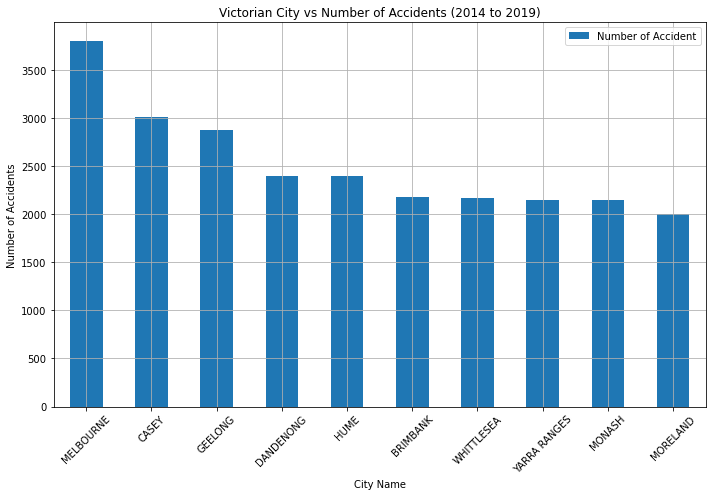

In [23]:
#Plot the information into a bar chat
first_10_chart =first_10_city_df.plot(kind="bar", 
                                 grid=True, 
                                 title="Victorian City vs Number of Accidents (2014 to 2019)", 
                                 figsize=(10,7))
first_10_chart.set_xlabel("City Name")
first_10_chart.set_ylabel("Number of Accidents")
first_10_chart.set_xticklabels(first_10_city_df["index"], rotation = 45)
plt.tight_layout()

In [24]:
# geocoordinates
target_radius = 5000
target_type = "hospital"

# set up a parameters dictionary
params = {"radius": target_radius,
    "type": target_type,
    "key": Api_Key
}

# base url
base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
params["location"]= "-37.9848, 145.214"

# run a request using our params dictionary, test the API works
response = requests.get(base_url, params=params)
response_json=response.json()
pprint(response_json)


{'html_attributions': [],
 'next_page_token': 'ATtYBwIuJHD5lEnrdXBXKa4Ub2vM8UtPKzhqBQjMqi7HpS7YDK6Oj33wrP0Bxj2P07S9O8VaL7eC0IAbVqpe8iz2Uj1ezgces-y8D0uhUFCaHuSaC9MQp5riXzkm5HmMmJowYseOWlJaOb7_pBgL0YLS4kaOjEydDMprYygODujWFHEOo_jcE6RA74G7snrlxyViI6_Jx8lj0WRo4wUltvNAoTyFPTIJqqzpcnAocNuVdBoxqnFuxze4n2Eh1mH37CLGFVb7ZpJb-Hed-DHstrLdqe3iEfWyFzvNnVk_2pHt5zYdxS0sZYa3YWhSsyM_gwDAM05BAIeMdvs34PCZlE-GwEHwA7lTwxBbeMfH1GZtWxrxkJruTk9GlyeAIfHyz7GVwOK5IB7R0lzoPDPAHf8e-v_yHSLqq94qtM9dFA3bIFbAE2AizKiNvrMdUw',
 'results': [{'business_status': 'OPERATIONAL',
              'geometry': {'location': {'lat': -37.97663729999999,
                                        'lng': 145.2184223},
                           'viewport': {'northeast': {'lat': -37.9755067197085,
                                                      'lng': 145.2198239802915},
                                        'southwest': {'lat': -37.9782046802915,
                                                      'lng': 145.2171260197085}}},
    

In [25]:
# Loop throught the dataframe, and call the API to find the nearst medical center in the city
for index, row in first_10_df.iterrows():
    # base url
    base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    
    lat=row["Latitude"]
    lng=row["Longitude"]
    params["location"] = f"{lat},{lng}"
    response = requests.get(base_url, params=params)
    response_json=response.json()
    results = response_json["results"]
    #pprint(results)
    #print(index)
    
    
    try:
        first_10_df.loc[index, "Closest Medical Centre"] = results[0]["name"]
        first_10_df.loc[index, "Address"] = results[0]["vicinity"]
        print("Finding nearst medical center in " + row["index"])
    except:
        print(row["index"] + " not found!")
        
    print("============================")

Finding nearst medical center in MELBOURNE
Finding nearst medical center in CASEY
Finding nearst medical center in GEELONG
Finding nearst medical center in DANDENONG
HUME not found!
Finding nearst medical center in BRIMBANK
Finding nearst medical center in WHITTLESEA
Finding nearst medical center in YARRA RANGES
Finding nearst medical center in MONASH
Finding nearst medical center in MORELAND


In [26]:
#Display the dataframe with the medical centre name
first_10_df.head(10)

,index,Number of Accident,Latitude,Longitude,Closest Medical Centre,Address
0,MELBOURNE,3803,-37.8136,144.963,Era Health Doctor Melbourne CBD,"Level 9/460 Bourke Street, Melbourne"
1,CASEY,3005,-38.1105,145.292,Blood Bank,"65 Berwick-Cranbourne Road, Cranbourne East"
2,GEELONG,2875,-38.1499,144.362,Dr. Natalie Harrison,"248 Malop Street, Geelong"
3,DANDENONG,2399,-37.9848,145.214,Dandenong Hospital,"135 David Street, Dandenong"
4,HUME,2396,-37.5987,144.829,,
5,BRIMBANK,2181,-37.7595,144.807,Western Health,"Furlong Road, St Albans"
6,WHITTLESEA,2172,-37.5139,145.114,Whittlesea Family Medical Centre,"4 Macmeikan Street, Whittlesea"
7,YARRA RANGES,2147,-37.7451,145.713,Warburton Medical Group,"3476 Warburton Highway, Warburton"
8,MONASH,2142,-37.9016,145.116,Monash Chiropractic Centre,"237 Ferntree Gully Road, Mount Waverley"
9,MORELAND,2005,-37.7241,144.95,Dorset Rehabilitation Centre,"146 Derby Street, Pascoe Vale"


In [27]:
# Using the template add the hotel marks to the heatmap
info_box_template = """
<dl>
<dt>Name</dt><dd>{Closest Medical Centre}</dd>
<dt>Address</dt><dd>{Address}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
medical_info1 = [info_box_template.format(**row) for index, row in first_10_df.iterrows()]
locations = first_10_df[["Latitude", "Longitude"]]

In [28]:
city = first_10_df["Number of Accident"] / 100

In [29]:
# Plot Heatmap
fig = gmaps.figure(map_type="TERRAIN")

# Create heat layer
#heat_layer = gmaps.heatmap_layer(locations, weights=city, 
#                                 dissipating=False, max_intensity=1000,
#                                 point_radius=0.01)

#Add layer
#fig.add_layer(heat_layer)

# Create symbol layer

symbol_layer = gmaps.marker_layer(locations, hover_text='', 
                      info_box_content=medical_info1 , display_info_box=None, label='')



fig.add_layer(symbol_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [30]:
#========End of Jing's part============

In [31]:
#======AJ's part =============

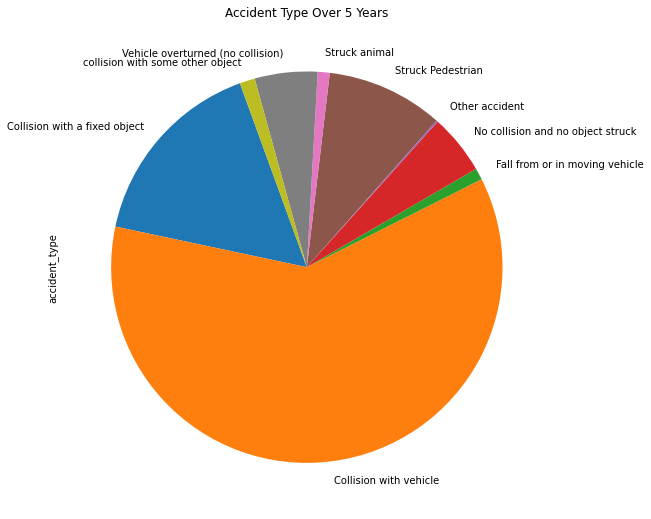

In [32]:
#Creating pie for all the 5 years for the accident types
accident_group = crash_df.groupby('accident_type')['accident_type'].count()
accident_chart = accident_group.plot(kind="pie", y='accident_type', title=("Accident Type Over 5 Years"), 
                                     legend=False, startangle=110, shadow=False, fontsize=10, figsize=(15,9))
plt.savefig("Accident Type Over 5 Years.png")

In [33]:
#Select only collumn required for Jing's part of analaysis
light_df = crash_df[['accident_no',  'accident_date', 'date_value', 
                      'accident_type',  'dca_code', 
                      'light_condition','longitude', 'latitude', 
                      'lga_name', 'region_name']]
light_df

,accident_no,accident_date,date_value,accident_type,dca_code,light_condition,longitude,latitude,lga_name,region_name
0,T20140013514,1/7/2014,41821,Collision with vehicle,RIGHT THROUGH,Day,144.979861,-37.406699,MITCHELL,NORTHERN REGION
1,T20140013549,2/7/2014,41822,Collision with vehicle,U TURN,Dark Street lights on,-1.000000,-1.000000,WHITTLESEA,METROPOLITAN NORTH WEST REGION
2,T20140013561,2/7/2014,41822,collision with some other object,STRUCK OBJECT ON CARRIAGEWAY,Dusk/Dawn,NaN,NaN,KNOX,METROPOLITAN SOUTH EAST REGION
3,T20140013563,2/7/2014,41822,Collision with vehicle,CROSS TRAFFIC(INTERSECTIONS ONLY),Unk.,-1.000000,-1.000000,WYNDHAM,METROPOLITAN NORTH WEST REGION
4,T20140013567,2/7/2014,41822,Collision with vehicle,RIGHT THROUGH,Day,-1.000000,-1.000000,WYNDHAM,METROPOLITAN NORTH WEST REGION
...,...,...,...,...,...,...,...,...,...,...
77508,T20180000054,1/1/2018,43101,Collision with vehicle,OTHER ADJACENT (INTERSECTIONS ONLY),Day,145.998337,-36.011056,MOIRA,NORTH EASTERN REGION
77509,T20180000034,1/1/2018,43101,Struck Pedestrian,PED ON FOOTHPATH STRUCK BY VEHENTERING/LEAVING...,Day,142.477960,-38.393743,WARRNAMBOOL,SOUTH WESTERN REGION
77510,T20200012822,17/1/2019,43482,Struck Pedestrian,PARKED CAR RUN AWAY,Day,144.360016,-38.148875,GEELONG,SOUTH WESTERN REGION
77511,T20200013045,27/3/2019,43551,No collision and no object struck,UNKNOWN-NO DETAILS ON MANOEUVRES OF ROAD-USERS...,Unk.,144.991724,-37.839020,STONNINGTON,METROPOLITAN SOUTH EAST REGION


In [34]:
light_accid_df = pd.DataFrame(light_df["light_condition"].value_counts())
light_accid_df

,light_condition
Day,51859
Dark Street lights on,11716
Dusk/Dawn,6642
Dark No street lights,4295
Unk.,2033
Dark Street lights unknown,805
Dark Street lights off,163


In [35]:
light_accid_df=light_accid_df.rename(columns = {"light_condition" : "No of Accident"})

In [36]:
light_accid_df.reset_index()

,index,No of Accident
0,Day,51859
1,Dark Street lights on,11716
2,Dusk/Dawn,6642
3,Dark No street lights,4295
4,Unk.,2033
5,Dark Street lights unknown,805
6,Dark Street lights off,163


Text(0, 0.5, 'Number of Accidents')

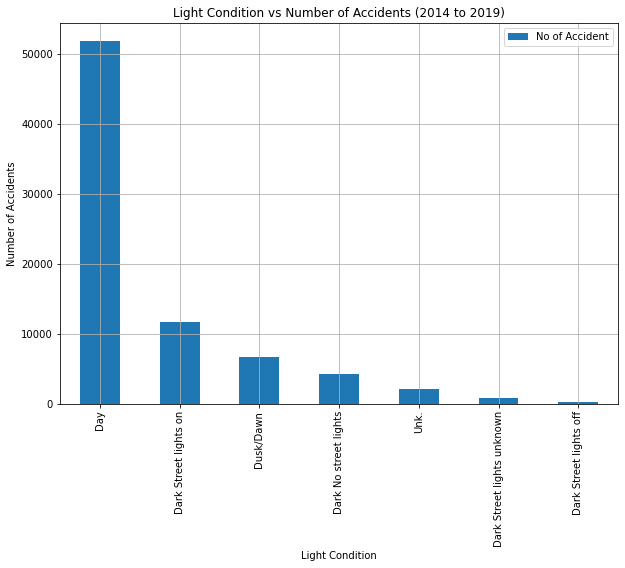

In [37]:
light_chart =light_accid_df.plot(kind="bar", 
                                 grid=True, 
                                 title="Light Condition vs Number of Accidents (2014 to 2019)", 
                                 figsize=(10,7))
light_chart.set_xlabel("Light Condition")
light_chart.set_ylabel("Number of Accidents")
#plt.tight_layout()

In [38]:
#creating a dataframe for the region
region_df = crash_df[['accident_no',  'accident_date', 'date_value', 
                      'accident_type',  'dca_code', 
                      'light_condition','longitude', 'latitude', 
                      'lga_name', 'region_name']]

In [39]:
#creating new dataframe for the region based on the value_counts
region_accid_df = pd.DataFrame(region_df["region_name"].value_counts())
region_accid_df

,region_name
METROPOLITAN SOUTH EAST REGION,27014
METROPOLITAN NORTH WEST REGION,26478
SOUTH WESTERN REGION,5819
EASTERN REGION,4580
NORTH EASTERN REGION,4530
NORTHERN REGION,4313
WESTERN REGION,4179
,600


In [40]:
#renaming the region name column
region_accid_df= region_accid_df.rename(columns = {"region_name" : "No of Accidents"})

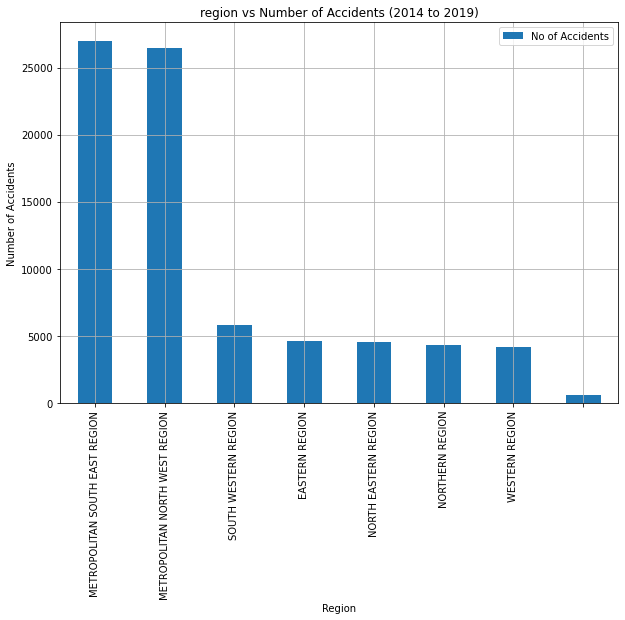

In [41]:
#plotting on a bar graph 
region_chart =region_accid_df.plot(kind="bar", grid=True, 
                                 title="region vs Number of Accidents (2014 to 2019)", 
                                 figsize=(10,7))
region_chart.set_xlabel("Region")
region_chart.set_ylabel("Number of Accidents")
plt.savefig("region vs Number of Accidents (2014 to 2019.png")

In [42]:
#creating a new dataframe to show accident_type by region
new_df = crash_df[['accident_no',  'accident_date', 'date_value', 
                      'accident_type',  'dca_code', 
                      'light_condition','longitude', 'latitude', 
                      'lga_name', 'region_name']]


In [43]:
#grouping the dataframe by accident_type and getting the values for each region
new_region_accid_df = crash_df.groupby("accident_type")['region_name'].value_counts()
new_region_accid_df.head(70)

accident_type                     region_name                   
Collision with a fixed object     METROPOLITAN SOUTH EAST REGION    3585
                                  METROPOLITAN NORTH WEST REGION    2682
                                  EASTERN REGION                    1371
                                  SOUTH WESTERN REGION              1324
                                  NORTH EASTERN REGION              1248
                                                                    ... 
collision with some other object  METROPOLITAN SOUTH EAST REGION     195
                                  EASTERN REGION                     150
                                  METROPOLITAN NORTH WEST REGION     115
                                  NORTHERN REGION                     94
                                  WESTERN REGION                      91
Name: region_name, Length: 70, dtype: int64

In [44]:
#creating a dataframe for suburbs
suburb_df = crash_df[['accident_no',  'accident_date', 'date_value', 
                      'accident_type',  'dca_code', 
                      'light_condition','longitude', 'latitude', 
                      'lga_name', 'region_name']]

In [45]:
#decalring accident_date as datetime.
suburb_df['accident_date'] =  pd.to_datetime(suburb_df['accident_date'], infer_datetime_format=True)


C:\Users\jingd\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
#extracting the year from the accident_date column and creating a year column.
suburb_df["year"] = suburb_df['accident_date'].map(lambda x: x.year)
total_accidents = suburb_df.groupby('year')["accident_type"].count()
suburb_df

C:\Users\jingd\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,accident_no,accident_date,date_value,accident_type,dca_code,light_condition,longitude,latitude,lga_name,region_name,year
0,T20140013514,2014-01-07,41821,Collision with vehicle,RIGHT THROUGH,Day,144.979861,-37.406699,MITCHELL,NORTHERN REGION,2014
1,T20140013549,2014-02-07,41822,Collision with vehicle,U TURN,Dark Street lights on,-1.000000,-1.000000,WHITTLESEA,METROPOLITAN NORTH WEST REGION,2014
2,T20140013561,2014-02-07,41822,collision with some other object,STRUCK OBJECT ON CARRIAGEWAY,Dusk/Dawn,NaN,NaN,KNOX,METROPOLITAN SOUTH EAST REGION,2014
3,T20140013563,2014-02-07,41822,Collision with vehicle,CROSS TRAFFIC(INTERSECTIONS ONLY),Unk.,-1.000000,-1.000000,WYNDHAM,METROPOLITAN NORTH WEST REGION,2014
4,T20140013567,2014-02-07,41822,Collision with vehicle,RIGHT THROUGH,Day,-1.000000,-1.000000,WYNDHAM,METROPOLITAN NORTH WEST REGION,2014
...,...,...,...,...,...,...,...,...,...,...,...
77508,T20180000054,2018-01-01,43101,Collision with vehicle,OTHER ADJACENT (INTERSECTIONS ONLY),Day,145.998337,-36.011056,MOIRA,NORTH EASTERN REGION,2018
77509,T20180000034,2018-01-01,43101,Struck Pedestrian,PED ON FOOTHPATH STRUCK BY VEHENTERING/LEAVING...,Day,142.477960,-38.393743,WARRNAMBOOL,SOUTH WESTERN REGION,2018
77510,T20200012822,2019-01-17,43482,Struck Pedestrian,PARKED CAR RUN AWAY,Day,144.360016,-38.148875,GEELONG,SOUTH WESTERN REGION,2019
77511,T20200013045,2019-03-27,43551,No collision and no object struck,UNKNOWN-NO DETAILS ON MANOEUVRES OF ROAD-USERS...,Unk.,144.991724,-37.839020,STONNINGTON,METROPOLITAN SOUTH EAST REGION,2019


Text(0, 0.5, 'Number of Accidents')

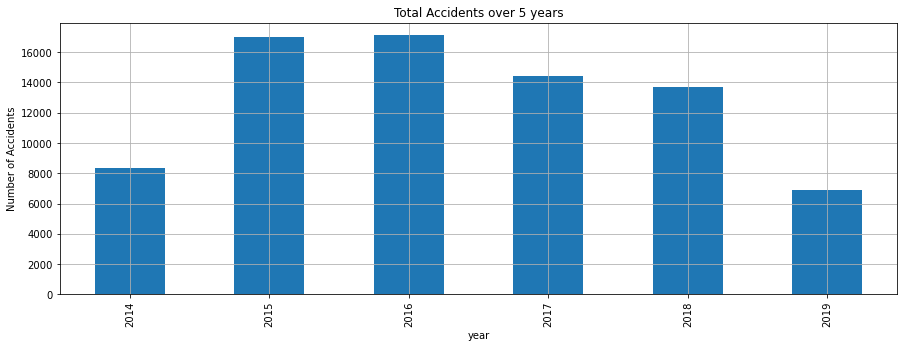

In [47]:
accident_chart =total_accidents.plot(kind="bar", 
                                 grid=True, 
                                 title="Total Accidents over 5 years", 
                                 figsize=(15,5))
accident_chart.set_xlabel("year")
accident_chart.set_ylabel("Number of Accidents")

In [48]:
new_suburb = suburb_df.loc[suburb_df["year"] != 2014]
new_suburb_02 = new_suburb.loc[new_suburb["year"] != 2019]

In [49]:
#creating accident_rate by groupping the df by year. And getting keys for the years.
accident_rate = new_suburb_02.groupby('year')["accident_type"].count()/ 100
years = accident_rate .keys()
years
accident_rate

year
2015    170.21
2016    171.09
2017    144.59
2018    136.82
Name: accident_type, dtype: float64

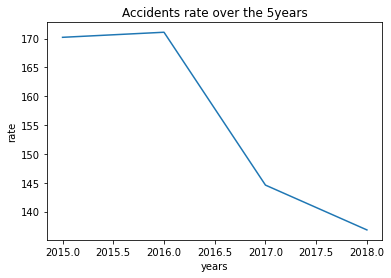

In [50]:
#accident_rate over the 5 year period 
plt.plot(years, accident_rate)
plt.title("Accidents rate over the 5years")
plt.xlabel("years")
plt.ylabel("rate")
plt.savefig("Accidents rate over the 5years.png")

The r-squared is: 0.865183463177266


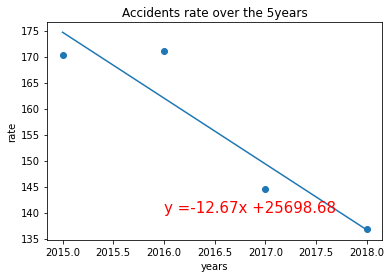

In [51]:
#created a regression between years and the accident rate but not sure wheather this is correct. 
vc_slope, vc_int, vc_r, vc_p, vc_std_err = stats.linregress(years, accident_rate)
vc_fit =  years * vc_slope + vc_int
plt.scatter(years, accident_rate)
plt.plot(years, vc_fit)
line_eq = "y =" + str(round(vc_slope,2)) + "x +" + str(round(vc_int,2))
plt.annotate(line_eq,(2016, 140), fontsize=15, color="red")
print(f"The r-squared is: {vc_r**2}")
plt.title("Accidents rate over the 5years")
plt.xlabel("years")
plt.ylabel("rate")
plt.savefig("Accidents rate over the 5years_regression.png")
plt.show()

In [52]:
#model = ols('Number of Accident ~ Latitude +  Longitude', data=first_10_df)
#fitted_model = model.fit()
#fitted_model.summary()

In [53]:
#Start of Stuart's Part********************************************

In [54]:
import os 
import pandas as pd
import gmaps
import requests
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
%matplotlib inline

In [55]:
# Weekday vs accident df
weekday_df = crash_df["day_of_week"].value_counts()
weekday_df

Friday       11822
Thursday     11676
Wednesday    11385
Tuesday      11033
Monday       10558
Sunday       10170
Saturday      8509
Name: day_of_week, dtype: int64

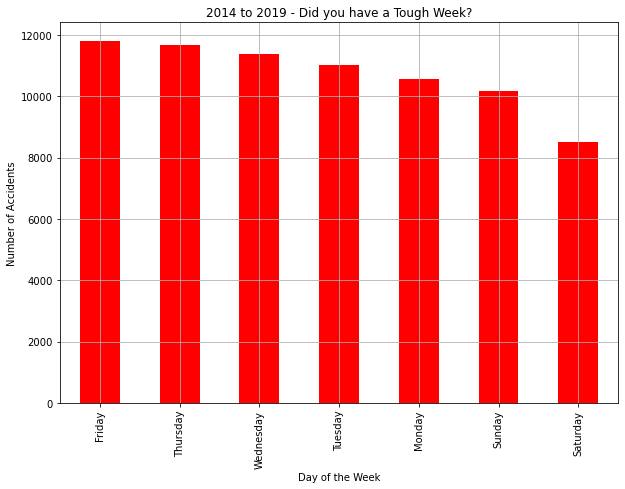

In [56]:
# Weekday vs accident "Left Handed"

weekday_chart =weekday_df.plot(kind="bar",
                                 grid=True,
                                 title="2014 to 2019 - Did you have a Tough Week?",
                                 figsize=(10,7), color='r')

plt.xlabel("Day of the Week")
plt.ylabel("Number of Accidents")
plt.show()

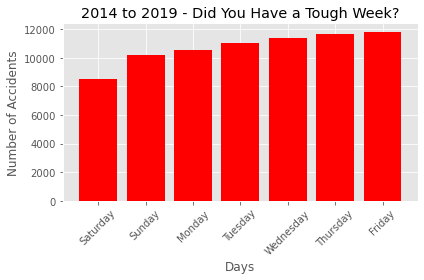

In [57]:
# Weekday vs accident "Right Handed"

plt.style.use('ggplot')
days = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
g = [8509, 10170, 10558, 11033, 11385, 11676, 11822]
x_pos = np.arange(len(days))
plt.bar(x_pos, g, color='r')
plt.xlabel("Days")
plt.ylabel("Number of Accidents")
plt.title("2014 to 2019 - Did You Have a Tough Week?")
plt.xticks(x_pos, days, rotation=45)
plt.tight_layout()
plt.savefig("../Bootcamp_ProjectOne/A Tough Week Jul_2014 to Jul_2019.png")

In [58]:
#***************YEAR BY YEAR*************************************************************************

In [59]:
#2015 Data Frame
fifteen_df_start = main_df.loc[main_df["date_value"] >=42005]
fifteen_df = fifteen_df_start.loc[fifteen_df_start["date_value"] <=42369]
fifteen_df.head()

,X,Y,objectid,accident_no,abs_code,accident_status,accident_date,date_value,Daily_Rainfall,accident_time,...,deg_urban_all,lga_name_all,region_name_all,srns,srns_all,rma,rma_all,divided,divided_all,stat_div_name
6024,2372860.721,2341281.939,6025,T20150000041,ABS to receive accident,Finished,1/1/2015,42005,0.0,19:30:00,...,RURAL_VICTORIA,COLAC OTWAY,SOUTH WESTERN REGION,NaN,NaN,Local Road,Local Road,Undivided,Undivided,Country
6043,2237269.143,2414740.680,6044,T20150000063,ABS to receive accident,Finished,2/1/2015,42006,0.0,8:30:00,...,TOWNS,SOUTHERN GRAMPIANS,SOUTH WESTERN REGION,NaN,NaN,Local Road,Local Road,Undivided,Undivided,Country
6045,2510112.501,2384968.933,6046,T20150000100,ABS to receive accident,Finished,2/1/2015,42006,0.0,19:30:00,...,MELB_URBAN,KINGSTON,METROPOLITAN SOUTH EAST REGION,NaN,NaN,Arterial Other,Arterial Other,Undivided,Undivided,Metro
6047,2408097.441,2567680.994,6048,T20150000106,ABS to receive accident,Finished,2/1/2015,42006,0.0,16:30:00,...,RURAL_VICTORIA,LODDON,NORTHERN REGION,B,B,Arterial Highway,Arterial Highway,Undivided,Undivided,Country
6048,2502775.869,2406361.982,6049,T20150000116,ABS to receive accident,Finished,2/1/2015,42006,0.0,22:05:00,...,MELB_URBAN,STONNINGTON,METROPOLITAN SOUTH EAST REGION,NaN,NaN,Arterial Other,Arterial Other,Undivided,Undivided,Metro


In [60]:
#2015 "day_of_week" Data Frame 
fifteendays_df = fifteen_df["day_of_week"].value_counts()
fifteendays_df

Thursday     2677
Friday       2603
Wednesday    2426
Tuesday      2360
Sunday       2307
Monday       2239
Saturday     1962
Name: day_of_week, dtype: int64

In [61]:
#2016 Data Frame
sixteen_df_start = main_df.loc[main_df["date_value"] >=42370]
sixteen_df = sixteen_df_start.loc[sixteen_df_start["date_value"] <=42735]
sixteen_df.head()

,X,Y,objectid,accident_no,abs_code,accident_status,accident_date,date_value,Daily_Rainfall,accident_time,...,deg_urban_all,lga_name_all,region_name_all,srns,srns_all,rma,rma_all,divided,divided_all,stat_div_name
20350,2508131.131,2414011.008,20351,T20160000013,ABS to receive accident,Finished,1/1/2016,42370,0.0,0:07:00,...,MELB_URBAN,MANNINGHAM,METROPOLITAN SOUTH EAST REGION,NaN,NaN,Arterial Other,Arterial Other,Divided,Divided,Metro
20351,2670674.079,2597526.088,20352,T20160000015,ABS to receive accident,Finished,1/1/2016,42370,0.0,2:35:00,...,SMALL_CITIES,WODONGA,NORTH EASTERN REGION,C,C,Arterial Other,Arterial Other,Divided,Divided,Country
20353,2509411.694,2387218.650,20354,T20160000051,ABS to receive accident,Finished,1/1/2016,42370,0.0,17:00:00,...,MELB_URBAN,KINGSTON,METROPOLITAN SOUTH EAST REGION,NaN,NaN,Arterial Other,"Local Road,Arterial Other",Divided,Divided,Metro
20377,2437544.124,2442575.685,20378,T20160000029,Non ABS accident,Finished,1/1/2016,42370,0.0,11:00:00,...,RURAL_VICTORIA,MOORABOOL,WESTERN REGION,NaN,NaN,NaN,NaN,NaN,NaN,Country
20413,2511572.772,2435626.758,20414,T20160000058,ABS to receive accident,Finished,1/1/2016,42370,0.0,16:40:00,...,MELB_URBAN,WHITTLESEA,METROPOLITAN NORTH WEST REGION,NaN,NaN,Local Road,Local Road,Undivided,Undivided,Metro


In [62]:
#2016 "day_of_week" Data Frame 
sixteendays_df = sixteen_df["day_of_week"].value_counts()
sixteendays_df

Friday       2634
Wednesday    2560
Thursday     2481
Tuesday      2392
Monday       2335
Sunday       2293
Saturday     1816
Name: day_of_week, dtype: int64

In [63]:
#2017 Data Frame
sevteen_df_start = main_df.loc[main_df["date_value"] >=42736]
sevteen_df = sevteen_df_start.loc[sevteen_df_start["date_value"] <=43100]
sevteen_df.head()

,X,Y,objectid,accident_no,abs_code,accident_status,accident_date,date_value,Daily_Rainfall,accident_time,...,deg_urban_all,lga_name_all,region_name_all,srns,srns_all,rma,rma_all,divided,divided_all,stat_div_name
33074,2494180.521,2409971.852,33075,T20160026415,ABS to receive accident,Finished,8/1/2017,42743,0.0,12:20:00,...,MELB_URBAN,MELBOURNE,METROPOLITAN NORTH WEST REGION,M,M,Freeway,Freeway,Divided,Divided,Metro
33870,2520183.923,2393094.277,33871,T20170000009,ABS to receive accident,Finished,1/1/2017,42736,0.0,2:40:00,...,MELB_URBAN,DANDENONG,METROPOLITAN SOUTH EAST REGION,M,M,Freeway,Freeway,Divided,Divided,Metro
33902,2434738.942,2498463.443,33903,T20170000024,ABS to receive accident,Finished,1/1/2017,42736,0.0,14:35:00,...,RURAL_VICTORIA,MOUNT ALEXANDER,NORTHERN REGION,NaN,NaN,Local Road,Local Road,Undivided,Undivided,Country
33903,2490641.428,2407013.080,33904,T20170000036,ABS to receive accident,Finished,1/1/2017,42736,0.0,0:15:00,...,MELB_URBAN,HOBSONS BAY,METROPOLITAN NORTH WEST REGION,NaN,NaN,Arterial Other,Arterial Other,Undivided,Undivided,Metro
33904,2521469.252,2395336.725,33905,T20170000041,ABS to receive accident,Finished,2/1/2017,42737,0.8,3:30:00,...,MELB_URBAN,KNOX,METROPOLITAN SOUTH EAST REGION,NaN,NaN,Local Road,Local Road,Undivided,Undivided,Metro


In [64]:
#2017 "day_of_week" Data Frame 
sevteendays_df = sevteen_df["day_of_week"].value_counts()
sevteendays_df

Friday       2206
Thursday     2147
Tuesday      2128
Wednesday    2089
Monday       2039
Sunday       1871
Saturday     1509
Name: day_of_week, dtype: int64

In [65]:
#2018 Data Frame
eigteen_df_start = main_df.loc[main_df["date_value"] >=43101]
eigteen_df = eigteen_df_start.loc[eigteen_df_start["date_value"] <=43465]
eigteen_df.head()

,X,Y,objectid,accident_no,abs_code,accident_status,accident_date,date_value,Daily_Rainfall,accident_time,...,deg_urban_all,lga_name_all,region_name_all,srns,srns_all,rma,rma_all,divided,divided_all,stat_div_name
45851,2687634.120,2529431.773,57080,T20180024557,ABS to receive accident,Finished,31/12/2018,43465,0.2,8:50:00,...,RURAL_VICTORIA,ALPINE,NORTH EASTERN REGION,C,C,Arterial Other,Arterial Other,Undivided,Undivided,Country
45852,2448989.415,2369136.955,57081,T20180024571,ABS to receive accident,Finished,31/12/2018,43465,0.2,16:55:00,...,LARGE_PROVINCIAL_CITIES,GEELONG,SOUTH WESTERN REGION,B,B,Arterial Highway,Arterial Highway,Divided,Divided,Country
45854,2527549.362,2368976.879,57082,T20180024573,ABS to receive accident,Finished,31/12/2018,43465,0.2,17:40:00,...,RURAL_VICTORIA,CASEY,METROPOLITAN SOUTH EAST REGION,NaN,NaN,Local Road,Local Road,Undivided,Undivided,Metro
45855,2443295.360,2368550.763,57083,T20180024581,ABS to receive accident,Finished,31/12/2018,43465,0.2,18:30:00,...,LARGE_PROVINCIAL_CITIES,GEELONG,SOUTH WESTERN REGION,NaN,NaN,Local Road,Local Road,Undivided,Undivided,Country
45863,2670474.127,2596989.611,57084,T20180024582,ABS to receive accident,Finished,31/12/2018,43465,0.2,18:15:00,...,SMALL_CITIES,WODONGA,NORTH EASTERN REGION,M,M,Freeway,Freeway,Divided,Divided,Country


In [66]:
#2018 "day_of_week" Data Frame 
eigteendays_df = eigteen_df["day_of_week"].value_counts()
eigteendays_df

Thursday     2070
Wednesday    2064
Friday       2057
Tuesday      1972
Monday       1926
Sunday       1703
Saturday     1491
Name: day_of_week, dtype: int64

In [67]:
daysx = (["Friday", "Thursday", "Wednesday", "Tuesday", "Monday", "Sunday", "Saturday"])
Y2015 = [2603, 2677, 2426, 2360, 2239, 2307, 1962]
Y2016 = [2634, 2481, 2560, 2392, 2335, 2293, 1816]
Y2017 = [2206, 2147, 2089, 2128, 2039, 1871, 1509]
Y2018 = [2057, 2070, 2064, 1972, 1926, 1703, 1491]

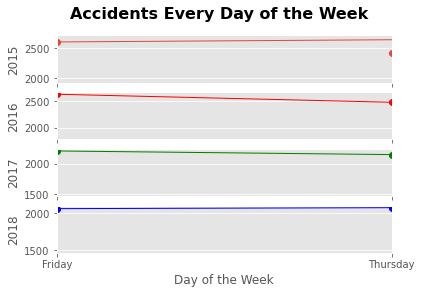

In [68]:
# Generate a facet plot of all 4 figures
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
fig.suptitle('Accidents Every Day of the Week', fontsize=16, fontweight="bold")


ax1.set_xlim(min(daysx), max(daysx))
ax1.plot(daysx, Y2015, linewidth=1, marker="o")
#ax1.plot(daysx, Y2015, "b--", linewidth=1)
ax1.set_ylabel("2015")

ax2.plot(daysx, Y2016, linewidth=1, marker="o", color="r")
#ax2.plot(daysx, Y2016, "r--", linewidth=1)
ax2.set_ylabel("2016")

ax3.plot(daysx, Y2017, linewidth=1, marker="o", color="g")
#ax3.plot(daysx, Y2017, "g--", linewidth=1)
ax3.set_ylabel("2017")

ax4.plot(daysx, Y2018, linewidth=1, marker="o", color="b")
#ax4.plot(daysx, Y2018, "b--", linewidth=1)
ax4.set_ylabel("2018")
ax4.set_xlabel("Day of the Week")

plt.show()

In [69]:
# Array rainfall amounts and count of accidents - "just playing with numbers"
rainfall_df = pd.DataFrame({
    "Rainfall":[0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 1.1, 1.2, 1.4, 1.6, 1.7, 1.8, 2, 2.2, 2.3, 2.4, 2.5, 2.6, 2.8, 3, 3.2, 3.4, 3.6, 3.7, 3.8, 4, 4.2, 4.4, 4.5, 4.6, 4.8, 4.9, 5, 5.2, 5.4, 5.5, 5.6, 5.8, 6, 6.2, 6.4, 6.6, 6.8, 7, 7.2, 7.4, 7.6, 7.8, 8, 8.2, 8.4, 8.5, 8.6, 8.8, 9.2, 9.6, 9.7, 9.8, 10, 10.2, 10.4, 10.6, 10.8, 11, 11.2, 11.4, 11.6, 11.8, 12, 12.2, 12.6, 12.8, 13, 13.6, 14.2, 14.4, 15, 15.2, 15.6, 15.8, 16, 16.2, 16.4, 16.6, 16.8, 17.4, 17.6, 17.8, 18, 18.6, 18.8, 19.2, 19.6, 20.6, 20.8, 21, 21.2, 21.6, 21.9, 22, 22.6, 22.8, 23.2, 25.5, 25.6, 27, 27.8, 28, 28.6, 29.6, 30.6, 35, 37.2, 38.4, 41.8, 47],
    "Accidents":[120,2943,50,1697,1474,1331,1161,35,1303,644,767,26,947,551,903,34,511,41,809,680,475,164,602,436,22,24,290,303,290,51,266,120,34,214,165,236,34,330,90,41,234,170,29,181,330,216,137,108,70,105,139,104,42,41,149,76,60,38,212,41,67,44,121,182,81,90,49,41,44,44,125,83,105,92,51,50,49,126,30,38,33,41,71,45,93,51,32,47,36,34,91,31,45,44,45,51,54,39,52,29,47,38,39,50,42,86,48,37,52,48,45,44,20,44,44,36,43]
})
rainfall_df.head()

,Rainfall,Accidents
0,0.1,120
1,0.2,2943
2,0.3,50
3,0.4,1697
4,0.6,1474


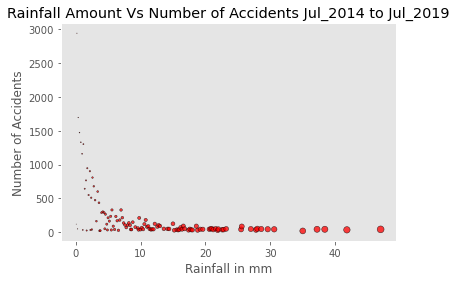

In [70]:
# Array numbers into a scatter plot
x_limit = 47
x_axis = [0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 1.1, 1.2, 1.4, 1.6, 1.7, 1.8, 2, 2.2, 2.3, 2.4, 2.5, 2.6, 2.8, 3, 3.2, 3.4, 3.6, 3.7, 3.8, 4, 4.2, 4.4, 4.5, 4.6, 4.8, 4.9, 5, 5.2, 5.4, 5.5, 5.6, 5.8, 6, 6.2, 6.4, 6.6, 6.8, 7, 7.2, 7.4, 7.6, 7.8, 8, 8.2, 8.4, 8.5, 8.6, 8.8, 9.2, 9.6, 9.7, 9.8, 10, 10.2, 10.4, 10.6, 10.8, 11, 11.2, 11.4, 11.6, 11.8, 12, 12.2, 12.6, 12.8, 13, 13.6, 14.2, 14.4, 15, 15.2, 15.6, 15.8, 16, 16.2, 16.4, 16.6, 16.8, 17.4, 17.6, 17.8, 18, 18.6, 18.8, 19.2, 19.6, 20.6, 20.8, 21, 21.2, 21.6, 21.9, 22, 22.6, 22.8, 23.2, 25.5, 25.6, 27, 27.8, 28, 28.6, 29.6, 30.6, 35, 37.2, 38.4, 41.8, 47],
data = [120,2943,50,1697,1474,1331,1161,35,1303,644,767,26,947,551,903,34,511,41,809,680,475,164,602,436,22,24,290,303,290,51,266,120,34,214,165,236,34,330,90,41,234,170,29,181,330,216,137,108,70,105,139,104,42,41,149,76,60,38,212,41,67,44,121,182,81,90,49,41,44,44,125,83,105,92,51,50,49,126,30,38,33,41,71,45,93,51,32,47,36,34,91,31,45,44,45,51,54,39,52,29,47,38,39,50,42,86,48,37,52,48,45,44,20,44,44,36,43]
plt.title("Rainfall Amount Vs Number of Accidents Jul_2014 to Jul_2019")
plt.xlabel("Rainfall in mm")
plt.ylabel("Number of Accidents")
plt.grid()
plt.scatter(x_axis, data, marker="o", facecolors="red", edgecolors="black",
            s=x_axis, alpha=0.75)

In [71]:
rain_crash_df = main_df[['accident_no',  'accident_date', 'date_value', 
                      'Daily_Rainfall']]
rain_crash_df 

,accident_no,accident_date,date_value,Daily_Rainfall
0,T20140013514,1/7/2014,41821,0.6
1,T20140013549,2/7/2014,41822,0.0
2,T20140013561,2/7/2014,41822,0.0
3,T20140013563,2/7/2014,41822,0.0
4,T20140013567,2/7/2014,41822,0.0
...,...,...,...,...
77508,T20180000054,1/1/2018,43101,0.0
77509,T20180000034,1/1/2018,43101,0.0
77510,T20200012822,17/1/2019,43482,0.0
77511,T20200013045,27/3/2019,43551,0.0


In [72]:
accident_count = rain_crash_df["accident_no"].value_counts()
accident_count

T20160013502    1
T20160017507    1
T20140021127    1
T20140022640    1
T20170015874    1
               ..
T20150006254    1
T20180000737    1
T20160023970    1
T20150010807    1
T20180014550    1
Name: accident_no, Length: 77513, dtype: int64

In [73]:
# Additional data set of rainfall data from BOM included in DoT data
file = "Resources/rain_vs_accident_five_years.csv"

rain_vs_acc = pd.read_csv(file)

rain_vs_acc.head()

,accident_date,date_value,daily_Rainfall_amount,count_of_accidents,correlation_rainfall_vs_accidents,-0.023604638
0,2/07/2014,41822,0.0,42,NaN,NaN
1,3/07/2014,41823,0.0,53,NaN,NaN
2,4/07/2014,41824,0.0,43,NaN,NaN
3,7/07/2014,41827,0.0,35,NaN,NaN
4,15/07/2014,41835,0.0,29,NaN,NaN


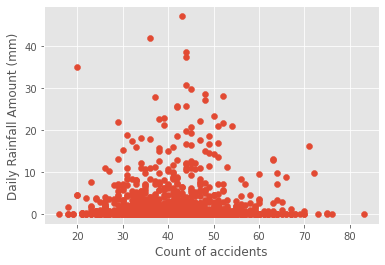

In [74]:
# Lets have a look
plt.scatter(rain_vs_acc.iloc[:,3],rain_vs_acc.iloc[:,2])
plt.ylabel('Daily Rainfall Amount (mm)')
plt.xlabel('Count of accidents')
plt.show()

In [75]:
#Import dependency
import scipy.stats as st

#Pearson correlation coefficient between "Daily Rainfall Amount" and "Number of Accidents"
dailyrainfall = rain_vs_acc.iloc[:,3]
countofcrash = rain_vs_acc.iloc[:,2]
correlation = st.pearsonr(dailyrainfall,countofcrash)
print(f"The correlation between both factors is {round(correlation[0],2)}")

The correlation between both factors is -0.02


The correlation between both factors is -0.02


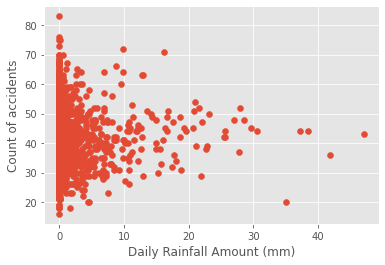

In [76]:
#Lets turn it on it's side O-O

dailyrainfall = rain_vs_acc.iloc[:,2]
countofcrash = rain_vs_acc.iloc[:,3]
plt.scatter(dailyrainfall,countofcrash)
plt.xlabel('Daily Rainfall Amount (mm)')
plt.ylabel('Count of accidents')

#Pearson correlation coefficient between "Daily Rainfall Amount" and "Number of Accidents"
correlation = st.pearsonr(dailyrainfall,countofcrash)
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.show()

In [77]:
#create the correlation df
corr_rainacc = rain_vs_acc[['daily_Rainfall_amount', 'count_of_accidents']]
corr_rainacc.head()

,daily_Rainfall_amount,count_of_accidents
0,0.0,42
1,0.0,53
2,0.0,43
3,0.0,35
4,0.0,29


In [78]:
#Rainfall vs count of accident correlation matrix to see (lack of) correlations
rain_corr = corr_rainacc.corr()
rain_corr.unstack().sort_values()

daily_Rainfall_amount  count_of_accidents      -0.023605
count_of_accidents     daily_Rainfall_amount   -0.023605
daily_Rainfall_amount  daily_Rainfall_amount    1.000000
count_of_accidents     count_of_accidents       1.000000
dtype: float64

In [79]:
# 'For Fun' all data correlation matrix "nothing to see here"
all_corr = main_df.corr()
all_corr.unstack().sort_values()

longitude         latitude           -0.957605
latitude          longitude          -0.957605
seriousinjury     otherinjury        -0.486792
otherinjury       seriousinjury      -0.486792
motorist          driver             -0.476051
                                        ...   
passenger         passenger           1.000000
ped_cyclist_5_12  ped_cyclist_5_12    1.000000
publicvehicle     publicvehicle       1.000000
vicgrid_y         Y                   1.000000
Y                 vicgrid_y           1.000000
Length: 1296, dtype: float64

The correlation between both factors is -0.02
The r-squared is: 0.0005571789284092713


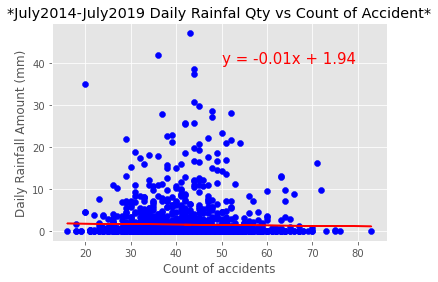

<Figure size 432x288 with 0 Axes>

In [80]:
#The final scatter

#Dependency
from scipy.stats import linregress

dailyrainfall = rain_vs_acc.iloc[:,3]
countofcrash = rain_vs_acc.iloc[:,2]
plt.scatter(dailyrainfall,countofcrash, color="b")
plt.xlabel('Count of accidents')
plt.ylabel('Daily Rainfall Amount (mm)')
plt.title('*July2014-July2019 Daily Rainfal Qty vs Count of Accident*')

#linear regression equation and line to plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(dailyrainfall, countofcrash)
regress_values = dailyrainfall * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(dailyrainfall,regress_values,"r-")
plt.annotate(line_eq,(50,40),fontsize=15,color="r")

#Pearson correlation coefficient between "Daily Rainfall Amount" and "Number of Accidents"
correlation = st.pearsonr(dailyrainfall,countofcrash)
print(f"The correlation between both factors is {round(correlation[0],2)}")

# Print out the r-squared value 
print(f"The r-squared is: {rvalue**2}")
plt.show()
plt.savefig("../Bootcamp_ProjectOne/Rainfall Vs Accidents Jul_2014 to Jul_2019.png")

In [81]:
# End of Stuart's Code........................................Have a nice day 

In [82]:
#========

In [83]:
#=========================== Kaayin's Part ===========================

In [84]:
##Find and show instances of each rainfall level to provide indication that data is skewed in the direction of days 
##with less rain

rainfall_only = crash_df.loc[:,["Daily_Rainfall"]]
# print(rainfall_only.value_counts())
print(rainfall_only.sum())

Daily_Rainfall    114187.0
dtype: float64


In [85]:
rainfall_only.head()

,Daily_Rainfall
0,0.6
1,0.0
2,0.0
3,0.0
4,0.0


In [86]:
counts_rainfall = rainfall_only["Daily_Rainfall"].value_counts()
rainfall_with_index = counts_rainfall.reset_index()
rainfall_with_index

# counts

renamed = rainfall_with_index.rename(columns={"index":"Rainfall Levels","Daily_Rainfall":"Instances Recorded"})
dropped_zero_rainfall_days2 = renamed.drop([0,0]).sort_values(by="Rainfall Levels",ascending=True)
dropped_zero_rainfall_days2

,Rainfall Levels,Instances Recorded
40,0.1,120
1,0.2,2943
68,0.3,50
2,0.4,1697
3,0.6,1474
...,...,...
117,35.0,20
80,37.2,44
83,38.4,44
102,41.8,36


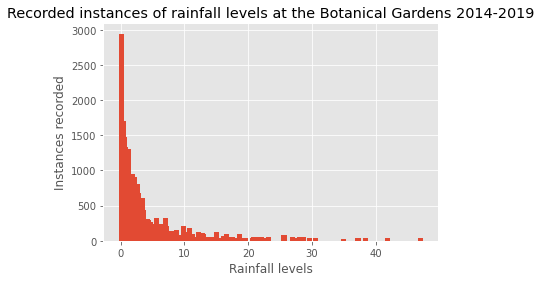

In [87]:
x_axis = dropped_zero_rainfall_days2["Rainfall Levels"]
# x_axis = hitandrun_yes["Daily_Rainfall"].astype("float")
y_axis = dropped_zero_rainfall_days2["Instances Recorded"]

plt.bar (x_axis,y_axis)
plt.title("Recorded instances of rainfall levels at the Botanical Gardens 2014-2019")
plt.xlabel("Rainfall levels")
plt.ylabel("Instances recorded")

plt.show()

In [88]:
##Find how many hit-and-runs per rainfall level

narrowed_data = crash_df.loc[:,["Daily_Rainfall","hit_run_flag"]]
# narrowed_data["hit_run_flag"].value_counts()
# narrowed_data["Daily_Rainfall"].value_counts()

narrowed_data

,Daily_Rainfall,hit_run_flag
0,0.6,No
1,0.0,No
2,0.0,No
3,0.0,Yes
4,0.0,No
...,...,...
77508,0.0,No
77509,0.0,No
77510,0.0,No
77511,0.0,No


In [89]:
##first by finding 'yes's...
hitandrun_yes = narrowed_data.loc[narrowed_data["hit_run_flag"]=="Yes"].sort_values(by="Daily_Rainfall",ascending=True)
hitandrun_yes

,Daily_Rainfall,hit_run_flag
3,0.0,Yes
48179,0.0,Yes
48180,0.0,Yes
48195,0.0,Yes
48206,0.0,Yes
...,...,...
75631,41.8,Yes
75646,41.8,Yes
75633,41.8,Yes
48624,47.0,Yes


In [90]:
counts = hitandrun_yes["Daily_Rainfall"].value_counts()
# floats = counts.astype("float")
yes_with_index = counts.reset_index()

# floats
yes_with_index

,index,Daily_Rainfall
0,0.0,2861
1,0.2,165
2,0.4,89
3,0.6,79
4,0.8,77
...,...,...
108,2.3,1
109,11.6,1
110,37.2,1
111,17.4,1


In [91]:
yes_with_index.sum()

index             1349.6
Daily_Rainfall    4317.0
dtype: float64

In [92]:
counts_of_yes = yes_with_index.rename(columns={"index":"Daily Rainfall","Daily_Rainfall":"Counts of 'Yes'"})
dropped_zero_rainfall_days = counts_of_yes.drop([0,0])
ascending = dropped_zero_rainfall_days.sort_values(by="Daily Rainfall",ascending=True)
ascending.head(50)

,Daily Rainfall,Counts of 'Yes'
28,0.1,11
1,0.2,165
95,0.3,2
2,0.4,89
3,0.6,79
4,0.8,77
8,1.0,53
86,1.1,2
6,1.2,59
13,1.4,38


In [93]:
ascending.sum()

Daily Rainfall     1349.6
Counts of 'Yes'    1456.0
dtype: float64

The r-squared is: 0.19019215471203801


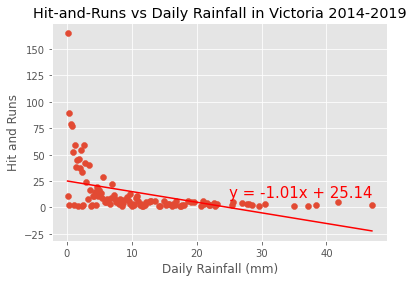

In [94]:
##plot instances of hit and runs per rainfall level and find line of regression

x_axis2 = ascending["Daily Rainfall"]
# x_axis = hitandrun_yes["Daily_Rainfall"].astype("float")
y_axis2 = ascending["Counts of 'Yes'"]

plt.scatter(x_axis2,y_axis2)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis2, y_axis2)
regress_values = x_axis2 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.annotate(line_eq,(25,10),fontsize=15,color="red")

plt.plot(x_axis2,regress_values,"r-")
print(f"The r-squared is: {rvalue**2}")

plt.title("Hit-and-Runs vs Daily Rainfall in Victoria 2014-2019")
plt.xlabel("Daily Rainfall (mm)")
plt.ylabel("Hit and Runs")

plt.show()

In [95]:
x_axis2
#daily rainfall levels

28      0.1
1       0.2
95      0.3
2       0.4
3       0.6
       ... 
112    35.0
110    37.2
92     38.4
58     41.8
88     47.0
Name: Daily Rainfall, Length: 112, dtype: float64

In [96]:
y_axis2
#"yes" responses

28      11
1      165
95       2
2       89
3       79
      ... 
112      1
110      1
92       2
58       5
88       2
Name: Counts of 'Yes', Length: 112, dtype: int64

In [97]:
##find how many crashes at dead-ends in Victoria are related to alcohol consumption

narrowed_data1 = crash_df.loc[crash_df["road_geometry"]=="Dead end"]
narrowed_again = narrowed_data1.loc[:,["road_geometry","alcohol_related"]]
numbers = narrowed_again["alcohol_related"].value_counts()
numbers

No     97
Yes     8
Name: alcohol_related, dtype: int64

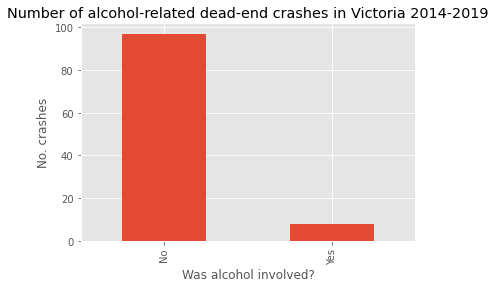

In [98]:
numbers.plot.bar()

plt.title("Number of alcohol-related dead-end crashes in Victoria 2014-2019")
plt.xlabel("Was alcohol involved?")
plt.ylabel("No. crashes")

plt.show()

In [99]:
##compare percentages of dead-end crashes under the influence of alcohol vs. not under the influence of alcohol

narrowed_alcohol = crash_df.loc[:,["road_geometry","alcohol_related"]]
yes_alcohol = narrowed_alcohol.loc[narrowed_alcohol["alcohol_related"]=="Yes"]
by_rg = yes_alcohol.groupby("road_geometry")
road_geometry_alcohol = by_rg.count().sort_values(by="alcohol_related",ascending=False)

road_geometry_alcohol2 = road_geometry_alcohol.reset_index()
road_geometry_alcohol2

,road_geometry,alcohol_related
0,Not at intersection,1705
1,T intersection,422
2,Cross intersection,237
3,Multiple intersection,24
4,Private property,21
5,Dead end,8
6,Y intersection,6
7,Unknown,4


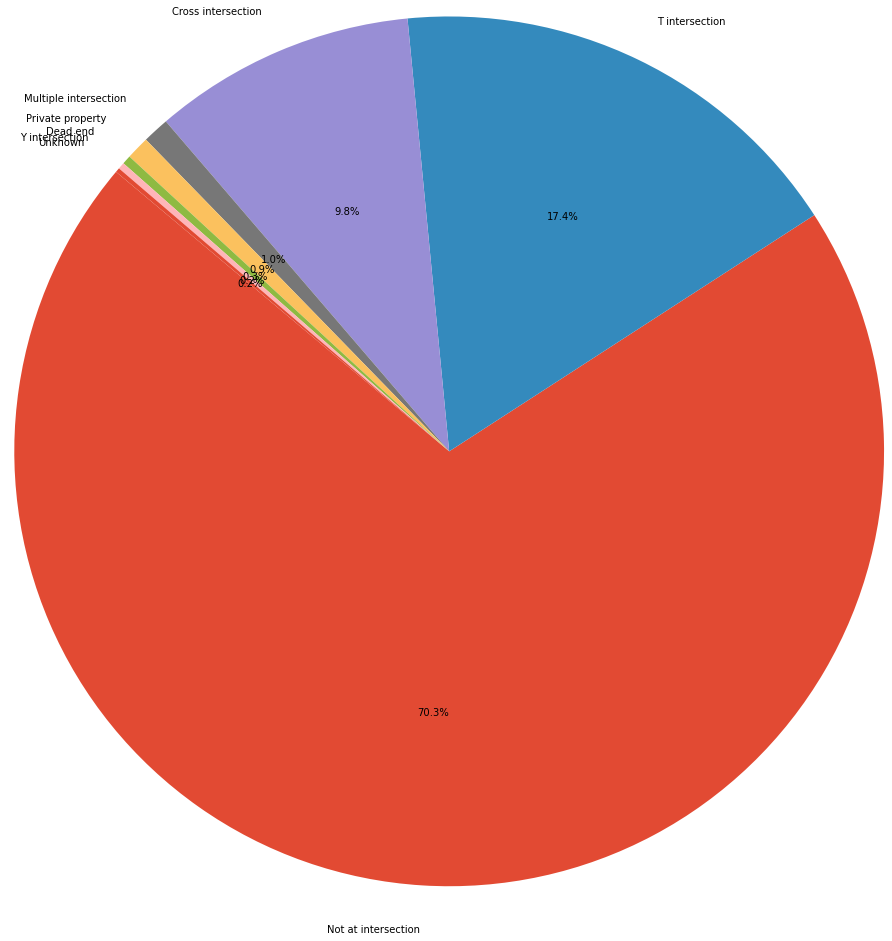

In [100]:
labels=road_geometry_alcohol2["road_geometry"]
values=road_geometry_alcohol2["alcohol_related"]

plt.pie(values, labels=labels,
        autopct="%1.1f%%", startangle=140,radius=5)

plt.show()

In [101]:
road_geometry_alcohol.loc["Dead end"]/2427*100

alcohol_related    0.329625
Name: Dead end, dtype: float64

In [102]:
print(road_geometry_alcohol.sum())

alcohol_related    2427
dtype: int64


In [103]:
narrowed_alcohol = crash_df.loc[:,["road_geometry","alcohol_related"]]
no_alcohol = narrowed_alcohol.loc[narrowed_alcohol["alcohol_related"]=="No"]
by_rg2 = no_alcohol.groupby("road_geometry")
road_geometry_no_alcohol = by_rg2.count().sort_values(by="alcohol_related",ascending=False)

road_geometry_no_alcohol2=road_geometry_no_alcohol.reset_index()
road_geometry_no_alcohol2

,road_geometry,alcohol_related
0,Not at intersection,38450
1,T intersection,15943
2,Cross intersection,15709
3,Unknown,1855
4,Multiple intersection,1505
5,Private property,1367
6,Y intersection,155
7,Dead end,97
8,Road closure,4


In [104]:
print(road_geometry_no_alcohol.sum())

alcohol_related    75085
dtype: int64


In [105]:
road_geometry_no_alcohol.loc["Dead end"]/75085*100

alcohol_related    0.129187
Name: Dead end, dtype: float64

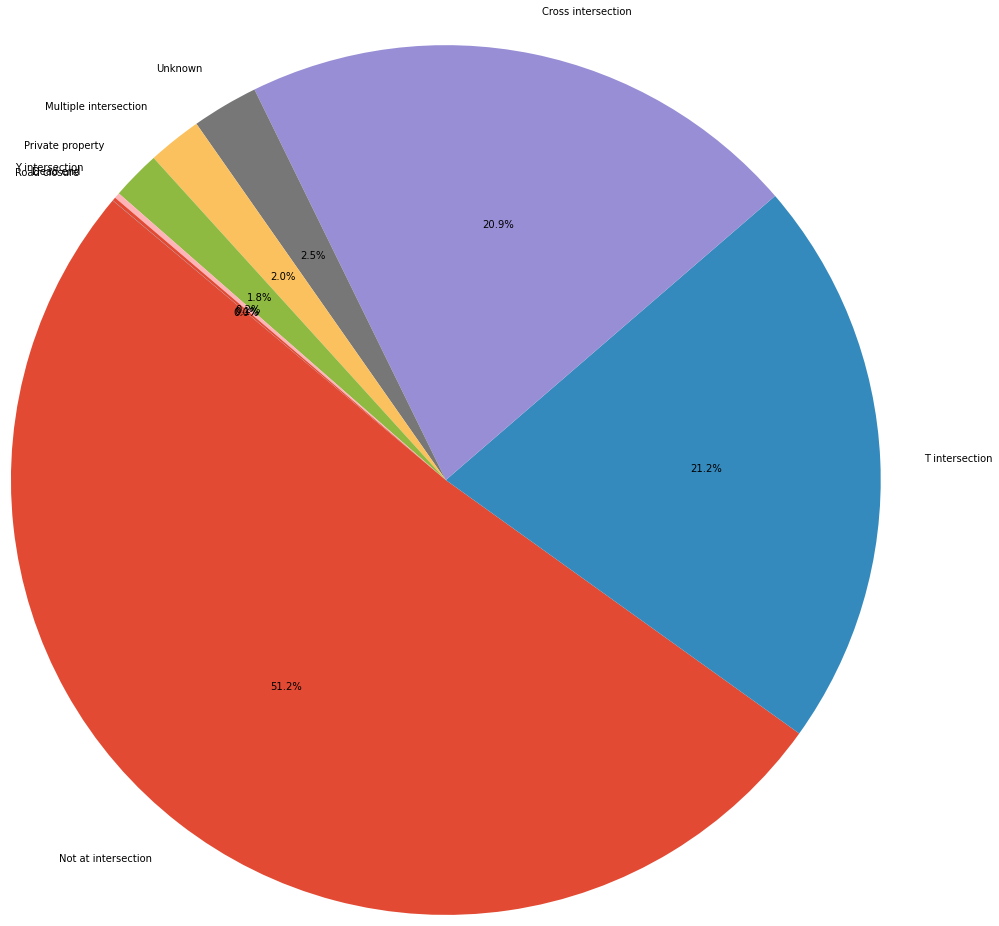

In [106]:
labels2=road_geometry_no_alcohol2["road_geometry"]
values2=road_geometry_no_alcohol2["alcohol_related"]

plt.pie(values2, labels=labels2,
        autopct="%1.1f%%", startangle=140,radius=5)

plt.show()

In [107]:
#=========================== End Kaayin's Part ===========================